In [38]:
%load_ext autoreload
%autoreload 2

from datasets import prepare_poison_dataset
from util import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Validating k-NN

In [39]:
k_range = lambda d: [
    d/2500,
    d/1000,
    d/500,
    d/400,
    d/300,
    d/200,
    d/100,
    d/50,   
    d/20,   # d/2num_classes 
]

k_range_str = [
    "N/2500",
    "N/1000",
    "N/500",
    "N/400",
    "N/300",
    "N/200",
    "N/100",
    "N/50",   
    "N/20"
]

In [40]:
results = {}

for dataset_name in ["badnets1", "badnets10", "wanet", "sig"]:

    results[dataset_name] = {}

    for train in [True, False]:
        
        train_str = "TRAIN" if train else "TEST"
        print(f"Testing {dataset_name} {train_str}")
        results[dataset_name][train_str] = {}

        dataset_size = 50000 if train else 10000
        for k, k_str in zip(k_range(dataset_size), k_range_str):

            k = int(k)
            poison_rates = []
            clean_kepts = []
            for dataset_index in [0,1,2]:
                dataset_name_complete = dataset_name + "-" + str(dataset_index)

                simclr_model_name = f"{dataset_name_complete}-SimCLR.pt"
                dataset, true_poison_indices, _, _ = prepare_poison_dataset(dataset_name_complete, train)
                simclr, epochs = load_simclr(simclr_model_name)
                features, labels_poison, labels_true = extract_simclr_features(simclr, dataset)

                predicted_poison_indices_nondisruptive = knn_cleanse(features, labels_poison, n_neighbors=k)
                poison_rate, _, clean_kept = evaluate_cleanse(predicted_poison_indices_nondisruptive, true_poison_indices)

                poison_rates.append(poison_rate)
                clean_kepts.append(clean_kept)
        
            poison_rate = sum(poison_rates)/len(poison_rates)
            clean_kept = sum(clean_kepts)/len(clean_kepts)
            results[dataset_name][train_str][k_str] = (poison_rate, clean_kept)

            print(f"\tk = {k_str} = {k}:")
            print(f"\t\tpoison rate: {100*poison_rate: .2f}\t(", end="")
            for pr in poison_rates:
                print(f"{100*pr: .2f}, ", end="")
            print(")")
            print(f"\t\tclean kept:  {100*clean_kept: .2f}\t(", end="")
            for ck in clean_kepts:
                print(f"{100*ck: .2f}, ", end="")
            print(")")

            

Testing badnets1 TRAIN
	k = N/2500 = 20:
		poison rate:  0.02	( 0.01,  0.01,  0.04, )
		clean kept:   83.94	( 84.36,  83.73,  83.73, )
	k = N/1000 = 50:
		poison rate:  0.01	( 0.01,  0.01,  0.02, )
		clean kept:   82.66	( 83.09,  82.48,  82.41, )
	k = N/500 = 100:
		poison rate:  0.01	( 0.01,  0.00,  0.02, )
		clean kept:   81.81	( 82.24,  81.63,  81.56, )
	k = N/400 = 125:
		poison rate:  0.01	( 0.01,  0.00,  0.02, )
		clean kept:   81.56	( 81.97,  81.42,  81.28, )
	k = N/300 = 166:
		poison rate:  0.01	( 0.01,  0.00,  0.02, )
		clean kept:   81.29	( 81.71,  81.11,  81.07, )
	k = N/200 = 250:
		poison rate:  0.01	( 0.01,  0.01,  0.02, )
		clean kept:   80.93	( 81.32,  80.77,  80.69, )
	k = N/100 = 500:
		poison rate:  0.01	( 0.01,  0.01,  0.03, )
		clean kept:   80.19	( 80.67,  79.86,  80.04, )
	k = N/50 = 1000:
		poison rate:  0.02	( 0.02,  0.01,  0.03, )
		clean kept:   79.24	( 79.78,  78.86,  79.08, )
	k = N/20 = 2500:
		poison rate:  0.02	( 0.02,  0.01,  0.04, )
		clean kept:   77

In [41]:
print(results["badnets1"])
print(results["badnets10"])
print(results["wanet"])
print(results["sig"])

{'TRAIN': {'N/2500': (0.0001767084921525352, 0.8393670033670033), 'N/1000': (0.00012233016510798564, 0.8265858585858585), 'N/500': (0.00013179500086593805, 0.8180740740740741), 'N/400': (0.00010738264210078248, 0.8155690235690235), 'N/300': (0.00010770235741854252, 0.8129427609427609), 'N/200': (0.0001248871086834576, 0.8092525252525253), 'N/100': (0.00014277447261957108, 0.8018855218855219), 'N/50': (0.00016135496974532286, 0.7924040404040404), 'N/20': (0.00020028468218462954, 0.7725252525252525)}, 'TEST': {'N/2500': (0.001218244258502162, 0.8552861952861953), 'N/1000': (0.0003625831599207204, 0.8344444444444444), 'N/500': (0.000244532894419527, 0.8236363636363636), 'N/400': (0.00016347015601401064, 0.8210101010101011), 'N/300': (0.0002058739139177509, 0.816060606060606), 'N/200': (0.00016564006861655275, 0.8112121212121212), 'N/100': (0.00025159138394376985, 0.8008080808080807), 'N/50': (0.00025598714382958605, 0.787003367003367), 'N/20': (0.000264202286393324, 0.7622222222222222)}}


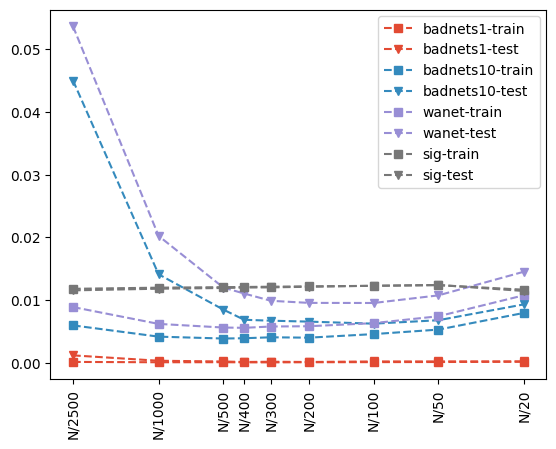

In [42]:
ks = k_range(10000)

def color(dataset_name):
    if dataset_name == "badnets1": return "#E24A33"
    elif dataset_name == "badnets10": return "#348ABD"
    elif dataset_name == "wanet": return "#988ED5"
    elif dataset_name == "sig": return "#777777"

def marker(train):
    if train: return "s"
    else: return "v"


for dataset_name in ["badnets1", "badnets10", "wanet", "sig"]:

    for train in [True, False]:

        train_str = "TRAIN" if train else "TEST"

        dataset_size = 50000 if train else 10000

        prs = []
        cks = []

        for k_str in k_range_str:
            poison_rate = results[dataset_name][train_str][k_str][0]
            clean_kept = results[dataset_name][train_str][k_str][1]

            prs.append(poison_rate)
            cks.append(clean_kept)

        plt.plot(ks, prs, linestyle="dashed", color=color(dataset_name), marker=marker(train), label=f"{dataset_name}-{train_str.lower()}")

plt.xscale("symlog")
plt.xticks(ks, k_range_str, rotation ='vertical')

plt.legend()
plt.show()

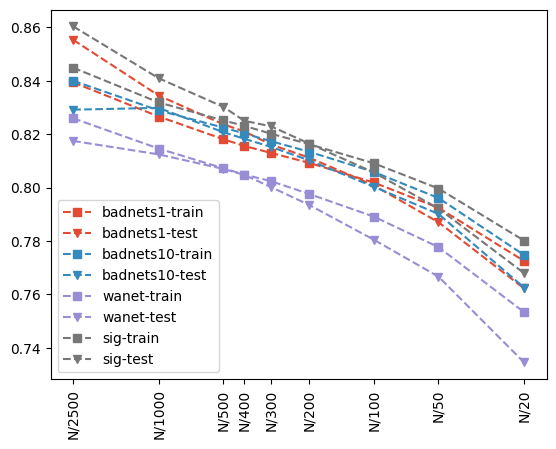

In [43]:
for dataset_name in ["badnets1", "badnets10", "wanet", "sig"]:

    for train in [True, False]:

        train_str = "TRAIN" if train else "TEST"

        dataset_size = 50000 if train else 10000

        prs = []
        cks = []

        for k_str in k_range_str:
            poison_rate = results[dataset_name][train_str][k_str][0]
            clean_kept = results[dataset_name][train_str][k_str][1]

            prs.append(poison_rate)
            cks.append(clean_kept)
        
        plt.plot(ks, cks, linestyle="dashed", color=color(dataset_name), marker=marker(train), label=f"{dataset_name}-{train_str.lower()}")

plt.xscale("symlog")
plt.xticks(ks, k_range_str, rotation ='vertical')

plt.legend()
plt.show()